In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax as jx
import jax.numpy as jnp
from jax.example_libraries import optimizers
from functools import partial

from tqdm import tqdm

key = jx.random.PRNGKey(0)

In [2]:
def init_params(layers, key, init='glorot_normal', activation='relu', **kwargs):
  #  https://pytorch.org/docs/stable/nn.init.html
  Ws = []
  bs = []
  gain = {
      'relu': jnp.sqrt(2),
      'tanh': 5/3,
      'selu': 3/4,
  }[activation]
    
  key, subkey = jx.random.split(key)
  fan_mode = 0 if kwargs.get('fan_mode', 'fan_in') else 1

  for i in range(len(layers) - 1):
    match init:
      case 'glorot_normal':
        std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
        Ws.append(jx.random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
        bs.append(jnp.zeros(layers[i + 1]))
      case 'he_normal':
        std_he = gain / jnp.sqrt(layers[i + fan_mode])
        Ws.append(jx.random.normal(subkey, (layers[i], layers[i + 1]))*std_he)
        bs.append(jnp.zeros(layers[i + 1]))
      case 'uniform':
        Ws.append(jx.random.uniform(subkey, (layers[i], layers[i+1])))
        bs.append(jnp.zeros(layers[i + 1]))
      case 'glorot_uniform':
        bound = gain * jnp.sqrt(6 / layers[i + fan_mode])
        Ws.append(jx.random.uniform(subkey, (layers[i], layers[i+1]), minval=-bound, maxval=bound))
        bs.append(jnp.zeros(layers[i + 1]))
      case 'he_uniform':
        bound = gain * jnp.sqrt(3 / layers[i + fan_mode])
        Ws.append(jx.random.uniform(subkey, (layers[i], layers[i+1]), minval=-bound, maxval=bound))
        bs.append(jnp.zeros(layers[i + 1]))
      case _:
        raise NotImplementedError(
            'Not available. Try:' +\
            ' glorot_normal, glorot_uniform' +\
            ', he_normal, he_uniform' +\
            ', uniform.'
        )
  return [Ws, bs]

@jx.jit
def forward_pass(H, params):
  # Forward pass with tanh
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = jnp.matmul(H, Ws[i]) + bs[i]
    H = jx.nn.relu(H)
    # H = jnp.tanh(H)
  Y = jnp.matmul(H, Ws[-1]) + bs[-1]
  return Y

def create_grads():
  fp_wrapper = lambda x, params: forward_pass(x, params)[0]
  du_dx = jx.grad(fp_wrapper)
  du_dx_wrapper = lambda x, params: du_dx(x, params)[0]
  dU_dx = jx.vmap(du_dx,in_axes=(0,None), out_axes=0)
  dU_dxx = jx.vmap(jx.grad(du_dx_wrapper),in_axes=(0,None), out_axes=0)
  return dU_dx, dU_dxx

grad_X, grad_XX = create_grads()

@partial(jx.jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    # Optimizer step
    params = get_params(opt_state)
    g = jx.grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, X_c, opt_state, X_bd = None, X_bn = None, nIter = 10000, stop=1e-5):
    train_loss = []
    val_loss = []
    key = jx.random.PRNGKey(0)
    for it in (pbar := tqdm(range(nIter))):
        opt_state = step(loss, it, opt_state, X, Y)
        if it % 50 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            pbar.set_description(f"{to_print}")
            if train_loss_value<stop:break
    return get_params(opt_state), train_loss, val_loss

@jx.jit
def one_pass(H, params):
  # Forward pass with tanh
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = jnp.matmul(H, Ws[i]) + bs[i]
    H = jx.nn.relu(H)
  return H

def train_ls(loss, X, Y, X_c, opt_state, X_bd = None, X_bn = None, nIter = 10000, stop=1e-5):
    train_loss = []
    val_loss = []
    key = jx.random.PRNGKey(0)
    for it in (pbar := tqdm(range(nIter))):
        opt_state = step(loss, it, opt_state, X, Y)
        params = get_params(opt_state)

        res_last = one_pass(X, params)
        vec_ext = jnp.c_[res_last, 1+0*res_last[:,0]]
        ls = (jnp.linalg.pinv(vec_ext)@Y)

        params[0][-1] = ls[:-1]
        params[1][-1] = ls[-1:]
        opt_state = opt_init(params)

        if it % 50 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            pbar.set_description(f"{to_print}")
            if train_loss_value<stop:break
    return get_params(opt_state), train_loss, val_loss


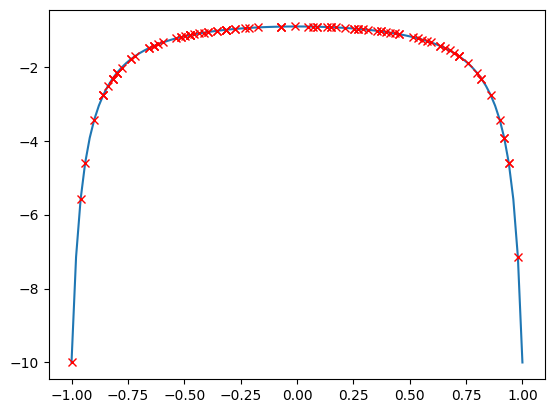

In [3]:
X = np.linspace(-1, 1, 100)[:, None]
Y = 1/(X**2-1.1)#np.cos(8.*X*np.pi)*np.exp(-8*X)
# Y /= Y.max()

rng_agent = np.random.default_rng(6516)
train_samples = rng_agent.choice(X.shape[0], 100)
X_train = X[train_samples]
Y_train = Y[train_samples]

plt.plot(X, Y)
plt.plot(X_train, Y_train, "rx")
plt.show()

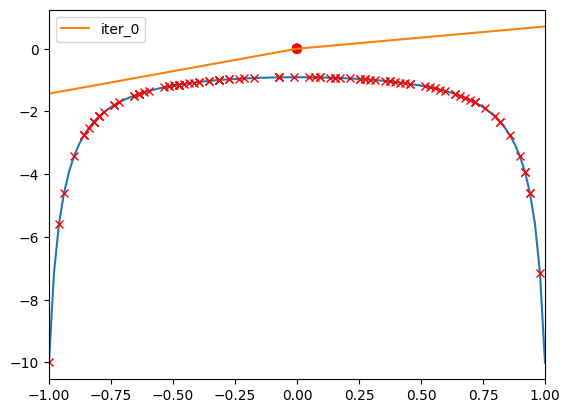

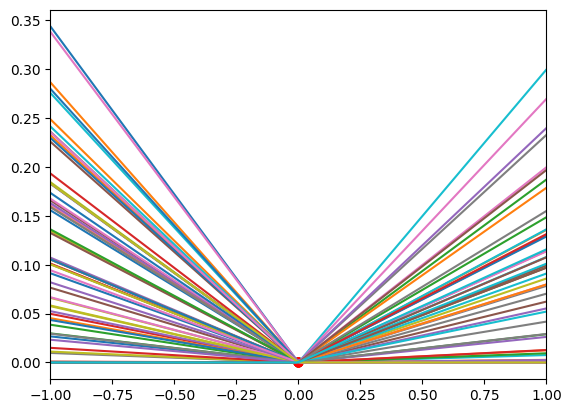

it 950, train loss = 9.277214e-01: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.08it/s]


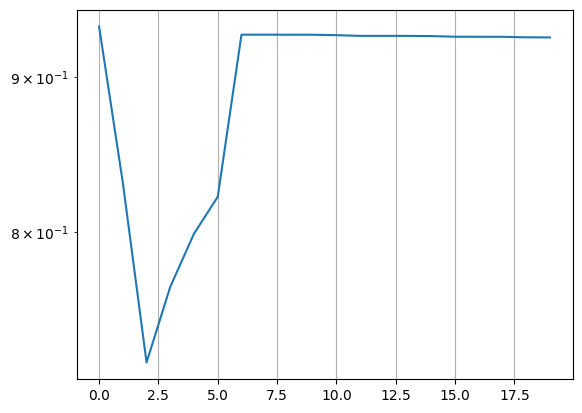

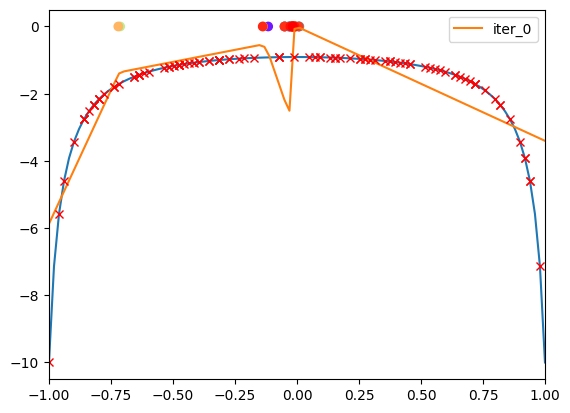

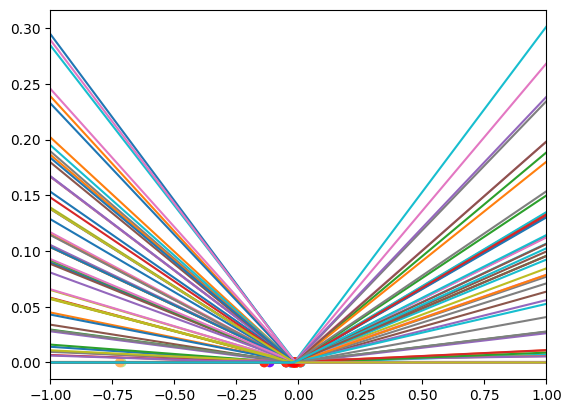

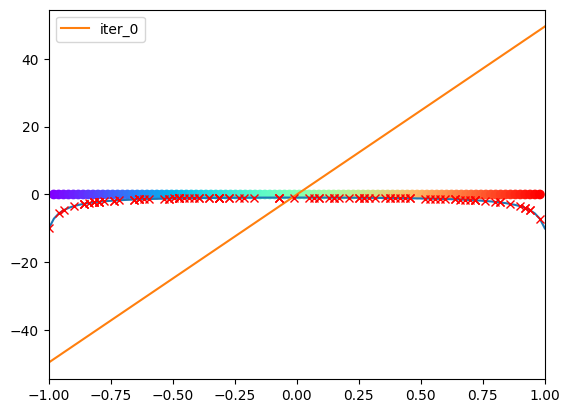

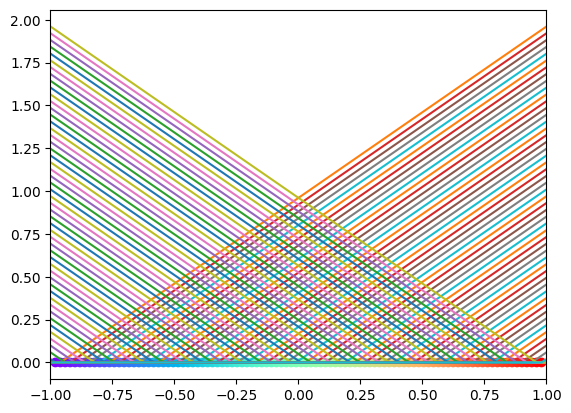

it 950, train loss = 1.071647e-06: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.01it/s]


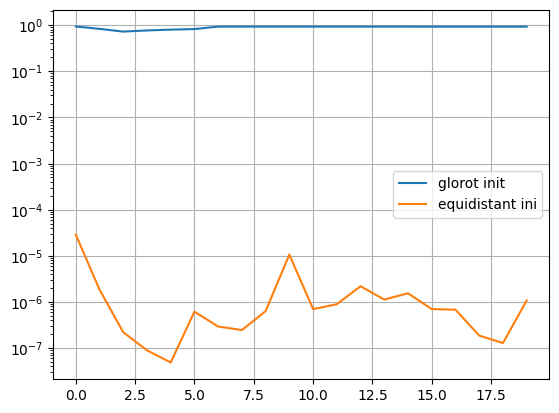

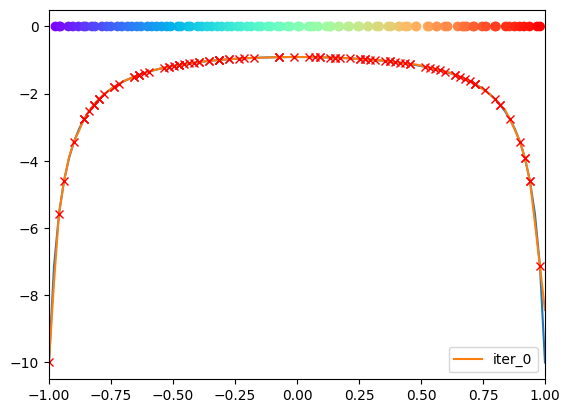

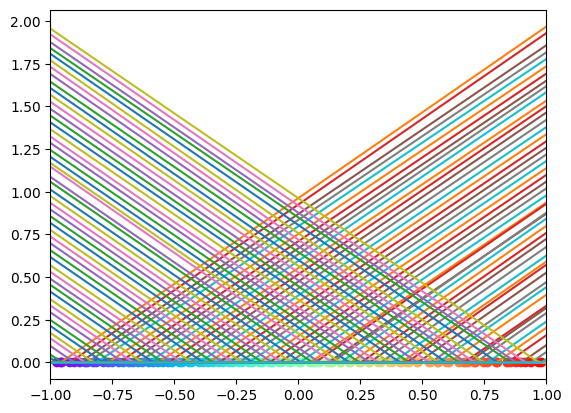

In [4]:
layers = [1] + [100]*1 + [1]
nIter = 1000
lr = 1e-4

key = jx.random.PRNGKey(0)
def init_params_modi(layers, key):
  # Glorot initialization
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = jx.random.split(key)
    c = jnp.linspace(-1, 1, layers[i + 1]+2)[1:-1]
    # Ws.append(jx.random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    # Ws.append(jnp.sign(jx.random.normal(subkey, (layers[i], layers[i + 1]))))
    # W = jx.random.normal(subkey, (layers[i], layers[i + 1]))+1
    W = np.ones((layers[i], layers[i + 1]))
    # W = np.array(W)
    W[::2,::2]*=-1

    Ws.append(W)
    # Ws.append(jnp.ones((layers[i], layers[i + 1])))
    # bs.append(jnp.zeros(layers[i + 1]))    
    bs.append(-W[0]*c)
  return [Ws, bs]

params_glorot = init_params(layers, key, init='glorot_normal', activation='relu')

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params_glorot)
def plt_state(params):
  W0, b0 = params
  W0 = W0[0]
  b0 = b0[0]
  plt.plot(X, Y)
  plt.plot(X, forward_pass(X, params), label="iter_0")
  plt.plot(X_train, Y_train, "rx")
  plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
  plt.xlim(-1, 1)
  plt.legend()
  plt.show()

  plt.plot(X, jx.nn.relu(X@W0+b0))
  plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
  plt.xlim(-1, 1)
  plt.show()

plt_state(params_glorot)

@jx.jit
def loss(params, X, Y):
    Y_pred = forward_pass(X, params)
    MSE = jnp.mean((Y_pred-Y)**2)
    return  MSE

# params, train_loss, val_loss = train(loss, X_train, Y_train, None, opt_state, nIter = nIter)
params_glorot, train_loss, val_loss = train_ls(loss, X_train, Y_train, None, opt_state, nIter = nIter, stop=1e-8)
opt_state = opt_init(params_glorot)

plt.semilogy()
plt.plot(train_loss)
plt.grid()
plt.show()

plt_state(params_glorot)

#modified init

params = init_params_modi(layers, key)

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)

plt_state(params)

# params, train_loss, val_loss = train(loss, X_train, Y_train, None, opt_state, nIter = nIter)
params, train_loss2, val_loss2 = train_ls(loss, X_train, Y_train, None, opt_state, nIter = nIter, stop=1e-8)
opt_state = opt_init(params)

plt.semilogy()
plt.plot(train_loss, label="glorot init")
plt.plot(train_loss2, label="equidistant ini")
plt.legend()
plt.grid()
plt.show()

plt_state(params)

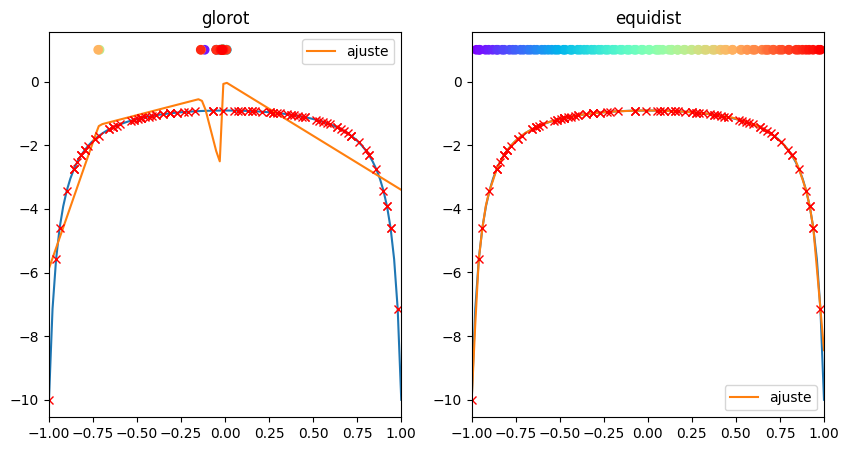

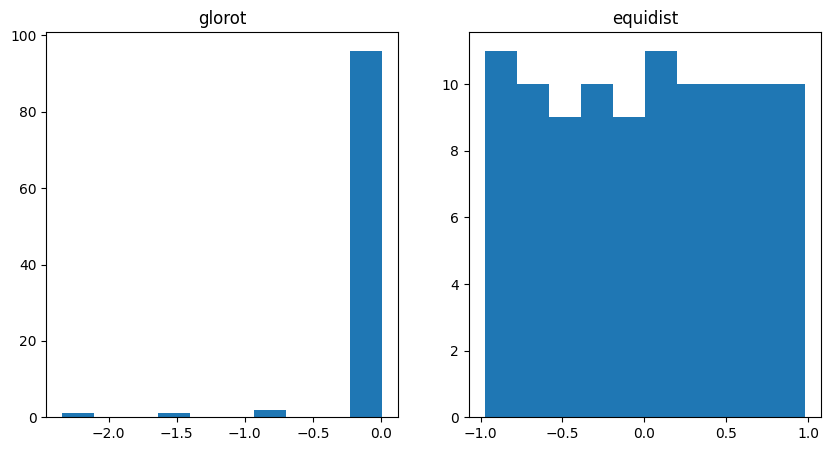

In [5]:
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1,2)
W0, b0 = params_glorot
W0 = W0[0]
b0 = b0[0]
ax[0].plot(X, Y)
ax[0].plot(X, forward_pass(X, params_glorot), label="ajuste")
ax[0].plot(X_train, Y_train, "rx")
ax[0].scatter(-b0/W0[0], [1]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
ax[0].set_xlim(-1, 1)
ax[0].legend()
W0, b0 = params
W0 = W0[0]
b0 = b0[0]
ax[1].plot(X, Y)
ax[1].plot(X, forward_pass(X, params), label="ajuste")
ax[1].plot(X_train, Y_train, "rx")
ax[1].scatter(-b0/W0[0], [1]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
ax[1].set_xlim(-1, 1)
ax[1].legend()
ax[0].set_title("glorot")
ax[1].set_title("equidist")
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1,2)

W0, b0 = params_glorot
W0 = W0[0]
b0 = b0[0]
ax[0].hist(-b0/W0[0])
W0, b0 = params
W0 = W0[0]
b0 = b0[0]
ax[1].hist(-b0/W0[0])
ax[0].set_title("glorot")
ax[1].set_title("equidist")
plt.show()

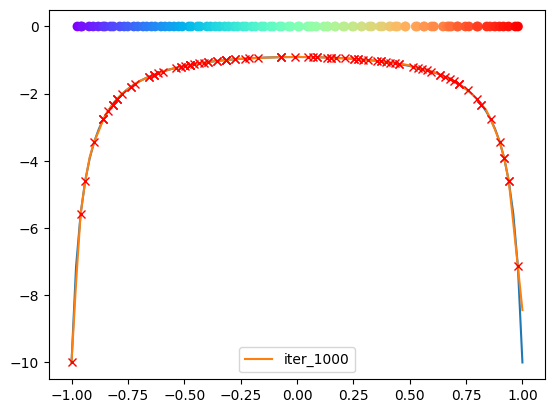

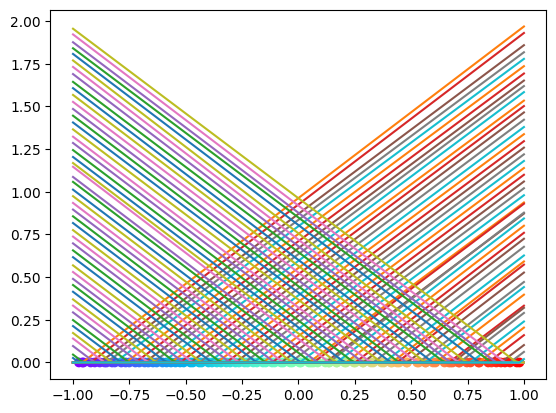

In [6]:

@jx.jit
def one_pass(H, params):
  # Forward pass with tanh
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = jnp.matmul(H, Ws[i]) + bs[i]
    H = jx.nn.relu(H)
  return H
res_last = one_pass(X_train, params)
vec_ext = jnp.c_[res_last, 1+0*res_last[:,0]]
ls = (jnp.linalg.pinv(vec_ext)@Y_train)

params[0][-1] = ls[:-1]
params[1][-1] = ls[-1:]

W0, b0 = params
W0 = W0[0]
b0 = b0[0]
plt.plot(X, Y)
plt.plot(X, forward_pass(X, params), label=f"iter_{nIter}")
plt.plot(X_train, Y_train, "rx")
plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
plt.legend()
plt.show()

plt.plot(X, jx.nn.relu(X@W0+b0))
plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
plt.show()

In [7]:
params

[[Array([[-1.003244  ,  1.0049464 , -0.99350387,  1.0044379 , -0.99880594,
           0.9879416 , -1.0001109 ,  0.9816216 , -0.9968919 ,  0.98002386,
          -0.9965004 ,  0.98243797, -0.9955414 ,  0.9820708 , -0.99805874,
           0.9815795 , -0.99810946,  0.9841081 , -0.99581116,  0.9878897 ,
          -0.9986486 ,  0.97990656, -0.99868065,  0.98489594, -0.9974298 ,
           0.99024   , -0.9973218 ,  0.9874312 , -0.997328  ,  0.985687  ,
          -1.0007195 ,  0.98185205, -1.0010475 ,  0.98181033, -1.0016992 ,
           0.9835983 , -1.0017847 ,  0.983894  , -1.0016682 ,  0.98358893,
          -1.0018497 ,  0.9841011 , -1.0017252 ,  0.98414737, -1.0017042 ,
           0.9842087 , -1.001697  ,  0.98425144, -1.0017235 ,  0.98452663,
          -1.0016251 ,  0.9831384 , -1.0012103 ,  0.99630487, -1.001447  ,
           0.9904881 , -1.0085479 ,  1.0137969 , -0.99857384,  1.0152761 ,
          -0.9987222 ,  1.0152143 , -0.99855644,  1.0148258 , -0.9991445 ,
           1.0157422 , -1

In [8]:
gL = jx.grad(lambda params: loss(params, X_train, Y_train))
ggL = jx.grad(gL)


gL(params)[0][-1], gL(params)[1][-1]#, ggL(params)

(Array([[-3.42995605e-07],
        [-5.02417679e-05],
        [ 3.08402015e-08],
        [-4.45349142e-05],
        [-9.21634410e-07],
        [-3.97415351e-05],
        [-1.06305845e-06],
        [-3.55661978e-05],
        [-1.88810554e-06],
        [-3.16656115e-05],
        [-3.32495870e-06],
        [-2.72382131e-05],
        [-4.99040334e-06],
        [-2.35520274e-05],
        [-7.23365065e-06],
        [-2.02555384e-05],
        [-9.45681859e-06],
        [-1.74227134e-05],
        [-1.16898891e-05],
        [-1.46717939e-05],
        [-1.48346780e-05],
        [-1.22535976e-05],
        [-1.77808142e-05],
        [-9.88374086e-06],
        [-2.05536871e-05],
        [-7.46861087e-06],
        [-2.39537840e-05],
        [-5.79296830e-06],
        [-2.76205847e-05],
        [-4.23054735e-06],
        [-3.23018539e-05],
        [-3.01732734e-06],
        [-3.64629086e-05],
        [-1.81203666e-06],
        [-4.09066743e-05],
        [-9.11679194e-07],
        [-4.54780020e-05],
 